# initialisation

In [1]:
!pip install python-chess==0.31.3
!pip install stockfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 1.3 MB/s eta 0:00:00


In [2]:
!sudo apt-get install git
!git clone https://github.com/official-stockfish/Stockfish.git
%cd Stockfish/src
!make build ARCH=x86-64

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'Stockfish'...
remote: Enumerating objects: 37335, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 37335 (delta 24), reused 25 (delta 21), pack-reused 37292
Receiving objects: 100% (37335/37335), 17.23 MiB | 4.31 MiB/s, done.
Resolving deltas: 100% (28839/28839), done.
/content/Stockfish/src
Default net: nn-e8bac1c07a5a.nnue
nn-e8bac1c07a5a.nnue available : OK
Network validated
Default net: nn-37f18f62d772.nnue
nn-37f18f62d772.nnue available : OK
Network validated

Config:
debug: 'no'
sanitize: 'none'
optimize: 'yes'
arch: 'x86_64'
bits: '64'
kernel: 'Linux'
os: 'GNU/Linux'
prefetch: 'yes'
popcnt: 'no'
pext: 'no'
sse: 'yes'
mmx: 'no'
sse2: 'yes'
ssse3: 'no'
sse41: 'no'
avx2: 'no'
avxvnni: 'no

# Stockfish + Board

In [3]:
import chess
import chess.engine
import random
import numpy

# this function will create our x (board)
def random_board(min_depth=1, max_depth=200):
  board = chess.Board()
  depth = random.randrange(min_depth, max_depth+1)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('/content/Stockfish/src/stockfish') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

In [4]:
from IPython.display import display, SVG, HTML
import chess.svg

def plot_board(board, taille=400):
    # Convert the board to SVG
    board_svg = chess.svg.board(board)

    # Ajouter des styles CSS pour contrôler la taille de l'image SVG
    svg_code = f'<svg width="{taille}"'
    svg_code += f' height="{taille}"'
    svg_code += f'>{board_svg}</svg>'

    # Afficher le SVG
    display(HTML(svg_code))

# Exemple d'utilisation :
board = random_board()
plot_board(board, taille=300)  # Choisit une largeur de 600 pixels, hauteur ajustée automatiquement

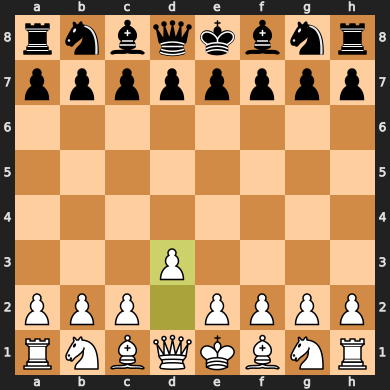

In [5]:
board = random_board(1,1)
board

In [6]:
print(stockfish(board, 1))
print(stockfish(board, 3))
print(stockfish(board, 5))
print(stockfish(board, 10))
print(stockfish(board, 15))

0
-13
-16
-4
-9


In [7]:
squares_index = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7
}

def square_to_index(square):
  letter = chess.square_name(square)
  return 8-int(letter[1]), squares_index[letter[0]]

def split_dims(board):
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
    i, j = square_to_index(move.to_square)
    board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
    i, j = square_to_index(move.to_square)
    board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [8]:
# split_dims(board)

# Dataset

In [ ]:
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm

# Monter Google Drive
drive.mount('/content/drive')
# Chemin vers le dossier dans Google Drive
drive_path = '/content/drive/My Drive/ChessDataset/'
# Créer le dossier si nécessaire
os.makedirs(drive_path, exist_ok=True)

# Fonction pour générer et sauvegarder le dataset
def generate_dataset(size, evaluation_depth=10, min_board_depth=2, max_board_depth=25, filename='dataset.npz'):
    boards = []
    evaluations = []

    for _ in tqdm(range(size), desc="Generating dataset"):
        board = random_board(min_board_depth, max_board_depth)
        evaluation = stockfish(board, evaluation_depth)
        if evaluation is not None:
            boards.append(split_dims(board))
            evaluations.append(evaluation)

    boards = np.array(boards)
    evaluations = np.array(evaluations)

    if len(evaluations) == 0:
        raise ValueError("No valid evaluations were obtained.")

    # Normalisation des évaluations
    evaluations = np.asarray(evaluations / abs(evaluations).max() / 2 + 0.5, dtype=np.float32)

    full_path = os.path.join(drive_path, filename)

    # Vérifier si le fichier existe déjà
    if os.path.exists(full_path):
        # Charger les données existantes
        existing_data = np.load(full_path)
        existing_boards = existing_data['b']
        existing_evaluations = existing_data['v']

        # Combiner les données existantes avec les nouvelles données
        boards = np.concatenate((existing_boards, boards))
        evaluations = np.concatenate((existing_evaluations, evaluations))

    # Sauvegarder les données combinées
    np.savez(full_path, b=boards, v=evaluations)

# Exemple d'utilisation pour générer un dataset de taille 25
generate_dataset(size=1000, evaluation_depth=7, min_board_depth=5, max_board_depth=9)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating dataset:   8%|▊         | 78/1000 [00:35<06:07,  2.51it/s]

In [ ]:
# # Télécharger le fichier .npz
# from google.colab import files

# # Télécharger le fichier de Google Drive vers l'espace local de Colab
# def download_dataset(filename='dataset.npz'):
#     full_path = os.path.join(drive_path, filename)
#     files.download(full_path)

# # Exemple d'utilisation pour télécharger le dataset
# download_dataset('dataset.npz')

In [10]:
import numpy as np
from google.colab import drive
import tensorflow.keras.callbacks as callbacks

# Monter Google Drive
drive.mount('/content/drive')

# Chemin vers le fichier .npz dans Google Drive
drive_path = '/content/drive/My Drive/ChessDataset/dataset.npz'

def get_dataset():
    container = np.load(drive_path)
    b, v = container['b'], container['v']
    v = np.asarray(v / abs(v).max() / 2 + 0.5, dtype=np.float32)
    return b, v

x_train, y_train = get_dataset()
print(x_train.shape)
print(y_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(16917, 14, 8, 8)
(16917,)


In [11]:
import numpy as np

def count_unique_values(filename):
    # Charger les données
    data = np.load(filename)
    boards = data['b']
    evaluations = data['v']

    # Trouver le nombre de valeurs uniques
    unique_boards = np.unique(boards, axis=0)
    unique_evaluations = np.unique(evaluations)

    return unique_boards.shape[0], unique_evaluations.shape[0]

# Exemple d'utilisation
filename = '/content/drive/My Drive/ChessDataset/dataset.npz'
num_unique_boards, num_unique_evaluations = count_unique_values(filename)

print(f"Nombre de plateaux uniques: {num_unique_boards}")
print(f"Nombre d'évaluations uniques: {num_unique_evaluations}")

Nombre de plateaux uniques: 15270
Nombre d'évaluations uniques: 5161


# Model

In [12]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  x = board3d
  for _ in range (conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

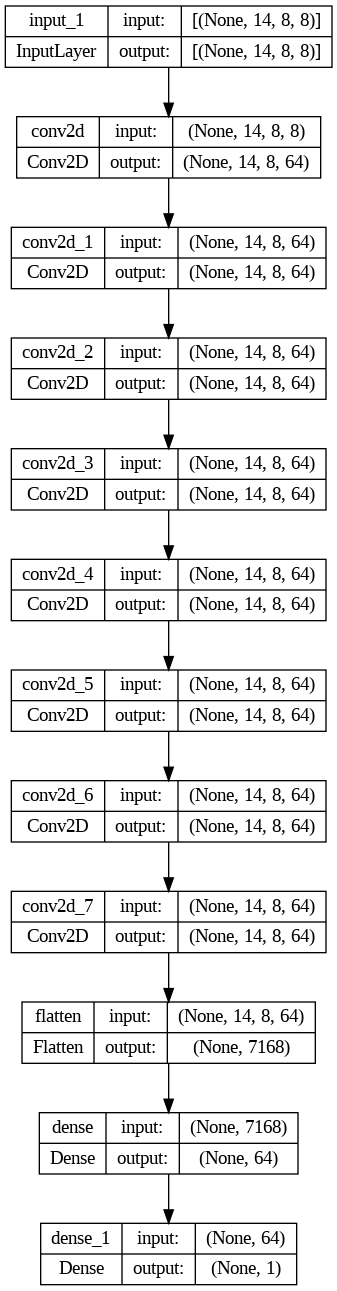

In [13]:
model = build_model(64, 8)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

# Train

In [14]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

model.compile(optimizer=optimizers.Adam(learning_rate=5e-4), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_split=0.1,
          callbacks=[
              callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=8, cooldown=5),
              callbacks.EarlyStopping(monitor='loss', patience=10, mode='min'),
              callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
              callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True),
              callbacks.CSVLogger(filename='training.log')
          ])

model.save('model.h5')

Num GPUs Available:  1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 64)         4672      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 8, 64)         36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 14

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 [==============================] - 12s 24ms/step - loss: 0.0038 - val_loss: 0.0031 - lr: 5.0000e-04
Epoch 2/5
238/238 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 0.0030 - lr: 5.0000e-04
Epoch 3/5
238/238 [==============================] - 2s 10ms/step - loss: 0.0025 - val_loss: 0.0027 - lr: 5.0000e-04
Epoch 4/5
238/238 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0028 - lr: 5.0000e-04
Epoch 5/5
238/238 [==============================] - 3s 13ms/step - loss: 0.0022 - val_loss: 0.0028 - lr: 5.0000e-04


# Game

In [15]:
import contextlib
import os
import sys

@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Usage in your minimax_eval function
def minimax_eval(board):
    board3d = split_dims(board)
    board3d = numpy.expand_dims(board3d, 0)
    with suppress_stdout():
        prediction = model.predict(board3d)
    return prediction[0][0]

def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval (board)

  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax (board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha= max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval

def get_ai_move(board, depth):
  max_move = None
  max_eval = -numpy.inf
  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, numpy.inf, numpy.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  return max_move

In [23]:
# Initialiser le plateau
board = chess.Board()

score_parti = []

# Démarrer le moteur d'échecs
with chess.engine.SimpleEngine.popen_uci('/content/Stockfish/src/stockfish') as engine:
    while True:
        # Jouer un coup avec Minimax
        move = get_ai_move(board,2)
        board.push(move)
        plot_board(board, taille=300)
        print("^ME", len(score_parti))
        if board.is_game_over():
            print("Me win")
            break
        score_parti.append(stockfish(board, 7))

        # Jouer un coup avec le moteur d'échecs
        result = engine.analyse(board, chess.engine.Limit(time=0.5), info=chess.engine.INFO_PV)
        move = result['pv'][0]
        board.push(move)
        plot_board(board, taille=300)
        print("^STOCK", len(score_parti))
        if board.is_game_over():
            print("Stock win")
            break
        score_parti.append(stockfish(board, 7))

^ME 0


^STOCK 1


^ME 2


^STOCK 3


^ME 4


^STOCK 5


^ME 6


^STOCK 7


^ME 8


^STOCK 9


^ME 10


^STOCK 11


^ME 12


^STOCK 13


^ME 14


^STOCK 15


^ME 16


^STOCK 17


^ME 18


^STOCK 19


^ME 20


^STOCK 21


^ME 22


^STOCK 23


^ME 24


^STOCK 25
Stock win


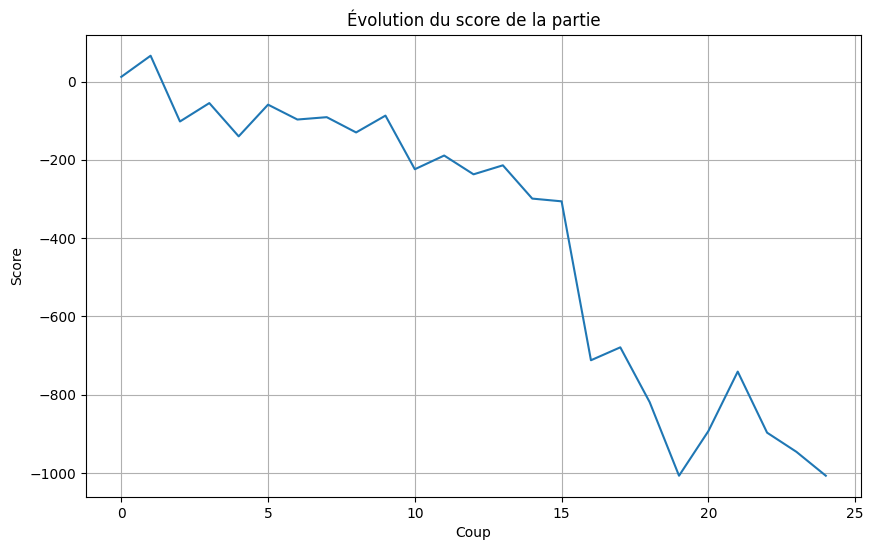

In [24]:
import matplotlib.pyplot as plt

# Remplacer les valeurs None par la valeur minimale non None
if None in score_parti:
    min_value = min(filter(lambda x: x is not None, score_parti))
    score_parti = [min_value if x is None else x for x in score_parti]

# Tracer le score de la partie
plt.figure(figsize=(10, 6))  # Taille de la figure
plt.plot(score_parti)
plt.xlabel('Coup')
plt.ylabel('Score')
plt.title('Évolution du score de la partie')
plt.grid(True)
plt.show()